# Project One: Market Segmentation

Market segmentation of computer games based on reviews scraped from https://www.commonsensemedia.org/ website. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
 
lemmatizer = WordNetLemmatizer()
# set of stop words
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kasia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kasia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load scraped data into a dataframe
df = pd.read_csv('csmedia_reviews.csv')

In [3]:
# Drop unnecessary columns and rename the others
del df['game_url']
df = df.rename({'game_review': 'review', 'game_age': 'recommended_age', }, axis=1) 

In [4]:
df.head()

,game_name,review,recommended_age
0,Cars 2: The Video Game,"Great combat racing, but loads of gunfire and ...",age 10+
1,Deus Ex: Human Revolution,"Mature themes, violence accompany mech-enhance...",age 18+
2,Gears of War 3,"Explosive, violent, and gory finale to the sci...",age 18+
3,FIFA Soccer 12,One of the best (and best-looking) sports simu...,age 8+
4,Forza Motorsport 4,Excellent racing sim that's easy to play but h...,age 10+


In [5]:
# Clean the recommended age column and change to integer
df['recommended_age'] = df['recommended_age'].apply(lambda x: int(x.replace("age ", "").replace("+", "")))

In [6]:
# Create a new column 'child safe' based on the recommended age column: if recommended age < 10: 1, else: 0

# Create a list of conditions
conditions = [
    (df['recommended_age'] < 10),
    (df['recommended_age'] > 10) 
    ]

# Create a list of the values we want to assign for each condition
values = [1, 0]

# Create a new column and use np.select to assign values to it using the above lists as arguments
df['child_safe'] = np.select(conditions, values)

In [7]:
df['child_safe'].value_counts()

0    496
1    124
Name: child_safe, dtype: int64

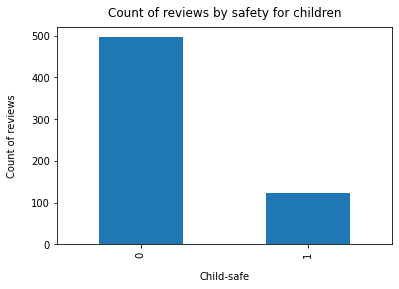

In [8]:
# Plot value_counts of the 'child safe' column
df['child_safe'].value_counts().plot(kind='bar')
plt.xlabel("Child-safe", labelpad=14)
plt.ylabel("Count of reviews", labelpad=14)
plt.title("Count of reviews by safety for children", y=1.02);

In [9]:
df.head()

,game_name,review,recommended_age,child_safe
0,Cars 2: The Video Game,"Great combat racing, but loads of gunfire and ...",10,0
1,Deus Ex: Human Revolution,"Mature themes, violence accompany mech-enhance...",18,0
2,Gears of War 3,"Explosive, violent, and gory finale to the sci...",18,0
3,FIFA Soccer 12,One of the best (and best-looking) sports simu...,8,1
4,Forza Motorsport 4,Excellent racing sim that's easy to play but h...,10,0


In [10]:
def preprocess_review(review):
    #remove punctuation
    tokenized = word_tokenize(str(review)) # tokenize
    tokenized_alnum = [word for word in tokenized if word.isalnum()] #alphanum only
    tokens_lowercase = [token.lower() for token in tokenized_alnum] #change all to lowercase
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens_lowercase] # lemmatize
    #add POS
    filtered_words = [word for word in lemmatized if word not in stopwords.words('english')] #remove stopwords
    return str(filtered_words)
    
df['review_preprocessed'] = df['review'].apply(lambda review: preprocess_review(review))
df['review_preprocessed']

0      ['great', 'combat', 'racing', 'load', 'gunfire...
1      ['mature', 'theme', 'violence', 'accompany', '...
2      ['explosive', 'violent', 'gory', 'finale', 'se...
3                 ['one', 'best', 'sport', 'simulation']
4      ['excellent', 'racing', 'sim', 'easy', 'play',...
                             ...                        
615    ['epic', 'violent', 'wwii', 'shooter', 'target...
616    ['polished', 'online', 'shooter', 'glamorizes'...
617           ['epic', 'adventure', 'force', 'reckoned']
618      ['excellent', 'math', 'game', 'fun', 'premise']
619           ['great', 'game', 'mixed', 'group', 'kid']
Name: review_preprocessed, Length: 620, dtype: object

In [11]:
df['review']

0      Great combat racing, but loads of gunfire and ...
1      Mature themes, violence accompany mech-enhance...
2      Explosive, violent, and gory finale to the sci...
3      One of the best (and best-looking) sports simu...
4      Excellent racing sim that's easy to play but h...
                             ...                        
615    Epic, violent WWII shooter targets soldiers' e...
616    Polished online shooter glamorizes intense gra...
617     Epic adventure is a "Force" to be reckoned with.
618                Excellent math game with fun premise.
619        Great game to have for a mixed group of kids.
Name: review, Length: 620, dtype: object

In [12]:
# define custom functions for machine learning
def crossvalidate_classifier(model, X, y, cm=False):
    
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=5)
    #scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
    print("%0.2f f-1 score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    y_pred = cross_val_predict(model, X, y, cv=5)

    if(cm):
        conf_mat = confusion_matrix(y, y_pred, labels=['fulfillment','other'])
        plot_confusion_matrix(conf_mat, classes = ['fulfillment','other'])
    
def evaluate_classifier(model, X_train, X_test, y_train, y_test):
      
    # ... fit your model here ...
    model.fit(X_train,y_train)

    # Run predict on your tfidf test data to get your predictions
    pred = model.predict(X_test)

    # Calculate your accuracy using the metrics module
    acc_score = metrics.accuracy_score(pred, y_test)
    print("Accuracy Score:   %0.3f" % acc_score)
    
    f1score = metrics.f1_score(pred, y_test, average='macro')
    print("F-1 Score:   %0.3f" % f1score)

    # Calculate the confusion matrices for the tfidf_svc model
    #svc_cm = metrics.confusion_matrix(y_test, pred, labels=['fulfillment','other'])

    # Plot the confusion matrix using the plot_confusion_matrix function
    #plot_confusion_matrix(svc_cm, classes = ['fulfillment','other'], title="Confusion Matrix")
    
    return model

def best_hyperparam(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='f1_score',
                       do_probabilities = False):
    gs = RandomizedSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data, epochs=100)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [13]:

X = df['review_preprocessed']
y = df['child_safe']
# Split your data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True, stratify=y )

In [14]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.05)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [15]:
print(count_train.shape, tfidf_train.shape)
print(count_vectorizer.vocabulary_)

(465, 50) (465, 50)
{'great': 23, 'combat': 6, 'racing': 34, 'load': 28, 'gunfire': 25, 'explosion': 12, 'violent': 48, 'greatest': 24, 'hit': 27, 'bundle': 3, 'loaded': 29, 'feature': 15, 'shooter': 38, 'violence': 47, 'one': 31, 'best': 1, 'sport': 42, 'simulation': 40, 'fun': 20, 'game': 21, 'bloody': 2, 'fantastic': 14, 'frantic': 19, 'open': 32, 'chat': 4, 'vast': 46, 'adventure': 0, 'epic': 9, 'wwii': 49, 'target': 44, 'soldier': 41, 'emotional': 8, 'toll': 45, 'explosive': 13, 'gory': 22, 'finale': 16, 'series': 37, 'excellent': 10, 'sim': 39, 'easy': 7, 'play': 33, 'ha': 26, 'mature': 30, 'rpg': 36, 'force': 18, 'reckoned': 35, 'exceptional': 11, 'take': 43, 'checkered': 5, 'flag': 17}


In [16]:
# Random Forest with Bag of Words
crossvalidate_classifier(RandomForestClassifier(), count_train, y_train)

1.00 f-1 score with a standard deviation of 0.00


In [17]:
# Random Forest with tf-idf 
crossvalidate_classifier(RandomForestClassifier(), tfidf_train, y_train)

1.00 f-1 score with a standard deviation of 0.00


In [18]:
# Gradient Boosting with Bag of Words
crossvalidate_classifier(GradientBoostingClassifier(), count_train, y_train)

1.00 f-1 score with a standard deviation of 0.00


In [19]:
# Gradient Boosting with tfidf
crossvalidate_classifier(GradientBoostingClassifier(), tfidf_train, y_train)

1.00 f-1 score with a standard deviation of 0.00
